## Meta-Visualization Framework for Spatiotemporal Analytics: 
### From Data Generation to Advanced Visualization on Maps

This notebook is dedicated to highlight the main technical aspects related to meta-visualization proposal

In [4]:
from PIL import Image
import folium
from folium.map import Marker

In [2]:
# Load map image
map_image = Image.open("soil.png")  # Replace "soil.png" with your map image file

We start by selecting a map scan to layer it on the map by georeferencing


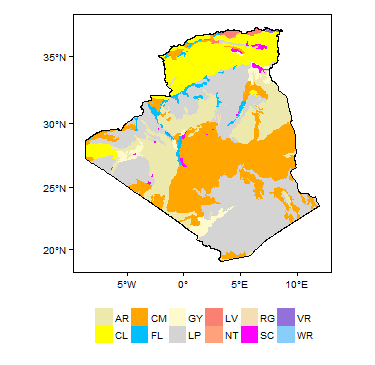

In [5]:
soil = folium.Map(location=[33, 0], zoom_start=4)

# Add a new image layer
folium.raster_layers.ImageOverlay(
    image='Algeria_soil.png',
    bounds=[[9.9, -16.1], [39.1, 16.8]],
    opacity=0.7,
    name='My Image Layer'
).add_to(soil)

# Save the map and display it
soil

Then, extracting the labels from the legend to compare the colors of each segment.

In [8]:
from pyproj import Proj, transform
import math

import warnings
warnings.filterwarnings("ignore")

from pyproj import Proj, transform
import math

def euclidean_distance(color1, color2):
    r1, g1, b1 = color1
    r2, g2, b2 = color2
    return math.sqrt((r1 - r2) ** 2 + (g1 - g2) ** 2 + (b1 - b2) ** 2)

def find_most_similar_color(rgb_color, color_list):
    min_distance = float('inf')
    most_similar_color = None

    for color_name, color in color_list.items():
        distance = euclidean_distance(rgb_color, color)
        if distance < min_distance:
            min_distance = distance
            most_similar_color = (color, color_name)

    return most_similar_color

# Dictionary of colors with their names
color_dict = {
    'AR': (237, 232, 171),
    'CL': (255, 255, 0),
    'CM': (255, 166, 0),
    'FL': (0, 191, 255),
    'GY': (255, 250, 204),
    'LP': (212, 212, 212),
    'LV': (250, 128, 115),
    'NT': (255, 161, 122),
    'RG': (245, 222, 197),
    'SC': (255, 0 , 255),
    'VR': (148, 112, 219),
    'WR': (135, 207, 250)
}


color_list = []

# Load map image
map_image = Image.open("soil.png")  # Replace "map.png" with your map image file

# Define the bounding box of the map in terms of latitude and longitude
# (min_latitude, min_longitude, max_latitude, max_longitude)
map_bbox = (9.9, -16.1, 39.09, 16.79)  # Example bounding box bounds=[[9.9, -16.1], [39.1, 16.8]],

# Determine the size of the map image in pixels
map_width, map_height = map_image.size

# Define the projection for the map (e.g., Web Mercator)
map_projection = Proj(init='epsg:3857')

# Convert latitude and longitude coordinates to pixel coordinates
def lat_lon_to_pixel(lat, lon):
    # Transform latitude and longitude to the map's projection
    x, y = transform(Proj(init='epsg:4326'), map_projection, lon, lat)
    # Scale the transformed coordinates to fit within the map image size
    pixel_x = int((x - map_projection(map_bbox[1], map_bbox[0])[0]) / 
                  (map_projection(map_bbox[3], map_bbox[0])[0] - map_projection(map_bbox[1], map_bbox[0])[0]) * map_width)
    pixel_y = int((map_projection(map_bbox[3], map_bbox[0])[1] - y) / 
                  (map_projection(map_bbox[3], map_bbox[2])[1] - map_projection(map_bbox[3], map_bbox[0])[1]) * map_height)
    return pixel_x, pixel_y


# Define intervals for latitude and longitude
latitude_interval = (9.9, 39.1)  # Example latitude interval
longitude_interval = (-16.1, 16.79)  # Example longitude interval

# Define segment size for precision e.g., 0.1 for high precision, and 0.5 for medium precision ...
latitude_step = 0.1  
longitude_step = 0.1  


# Generate latitude and longitude coordinates within the intervals
locations = []
for lat in range(int(latitude_interval[0] * 100), int(latitude_interval[1] * 100), int(latitude_step * 100)):
    for lon in range(int(longitude_interval[0] * 100), int(longitude_interval[1] * 100), int(longitude_step * 100)):
        locations.append((lat / 100, lon / 100))

# Loop over each location and get the color
for latitude, longitude in locations:
    # Convert latitude and longitude to pixel coordinates
    pixel_x, pixel_y = lat_lon_to_pixel(latitude, longitude)

    # Get the color of the pixel at the specified location
    pixel_color = map_image.getpixel((pixel_x, pixel_y))
    
    # Find the most similar color from the dictionary
    c, n = find_most_similar_color(pixel_color, color_dict)
    color_list.append({"latitude": latitude, "longitude": longitude, "color": pixel_color, "most similar": c, "type": n})

#print(color_list)

Note that higher precision requires significanlty more time for extraction than medium and lower precision.
The previous extraction step takes about 70 minutes.

We save the extracted properties as a list into a csv.

In [9]:
import pandas as pd
df = pd.DataFrame(color_list)
df.to_csv('extracted_soil_types.csv', index=True)

In [10]:
len(color_list)

96068

In [15]:
color_list[10000]

{'latitude': 12.9,
 'longitude': -3.1,
 'color': (251, 250, 249),
 'most similar': (255, 250, 204),
 'type': 'GY'}

We can choose to add another layer of properties from another map. For instance, bioclimatic stage map scan.

In [16]:
# Load map image
map_image = Image.open("etage_bioclimatique.png")  # Replace "etage_bioclimatique.png" with your map image file


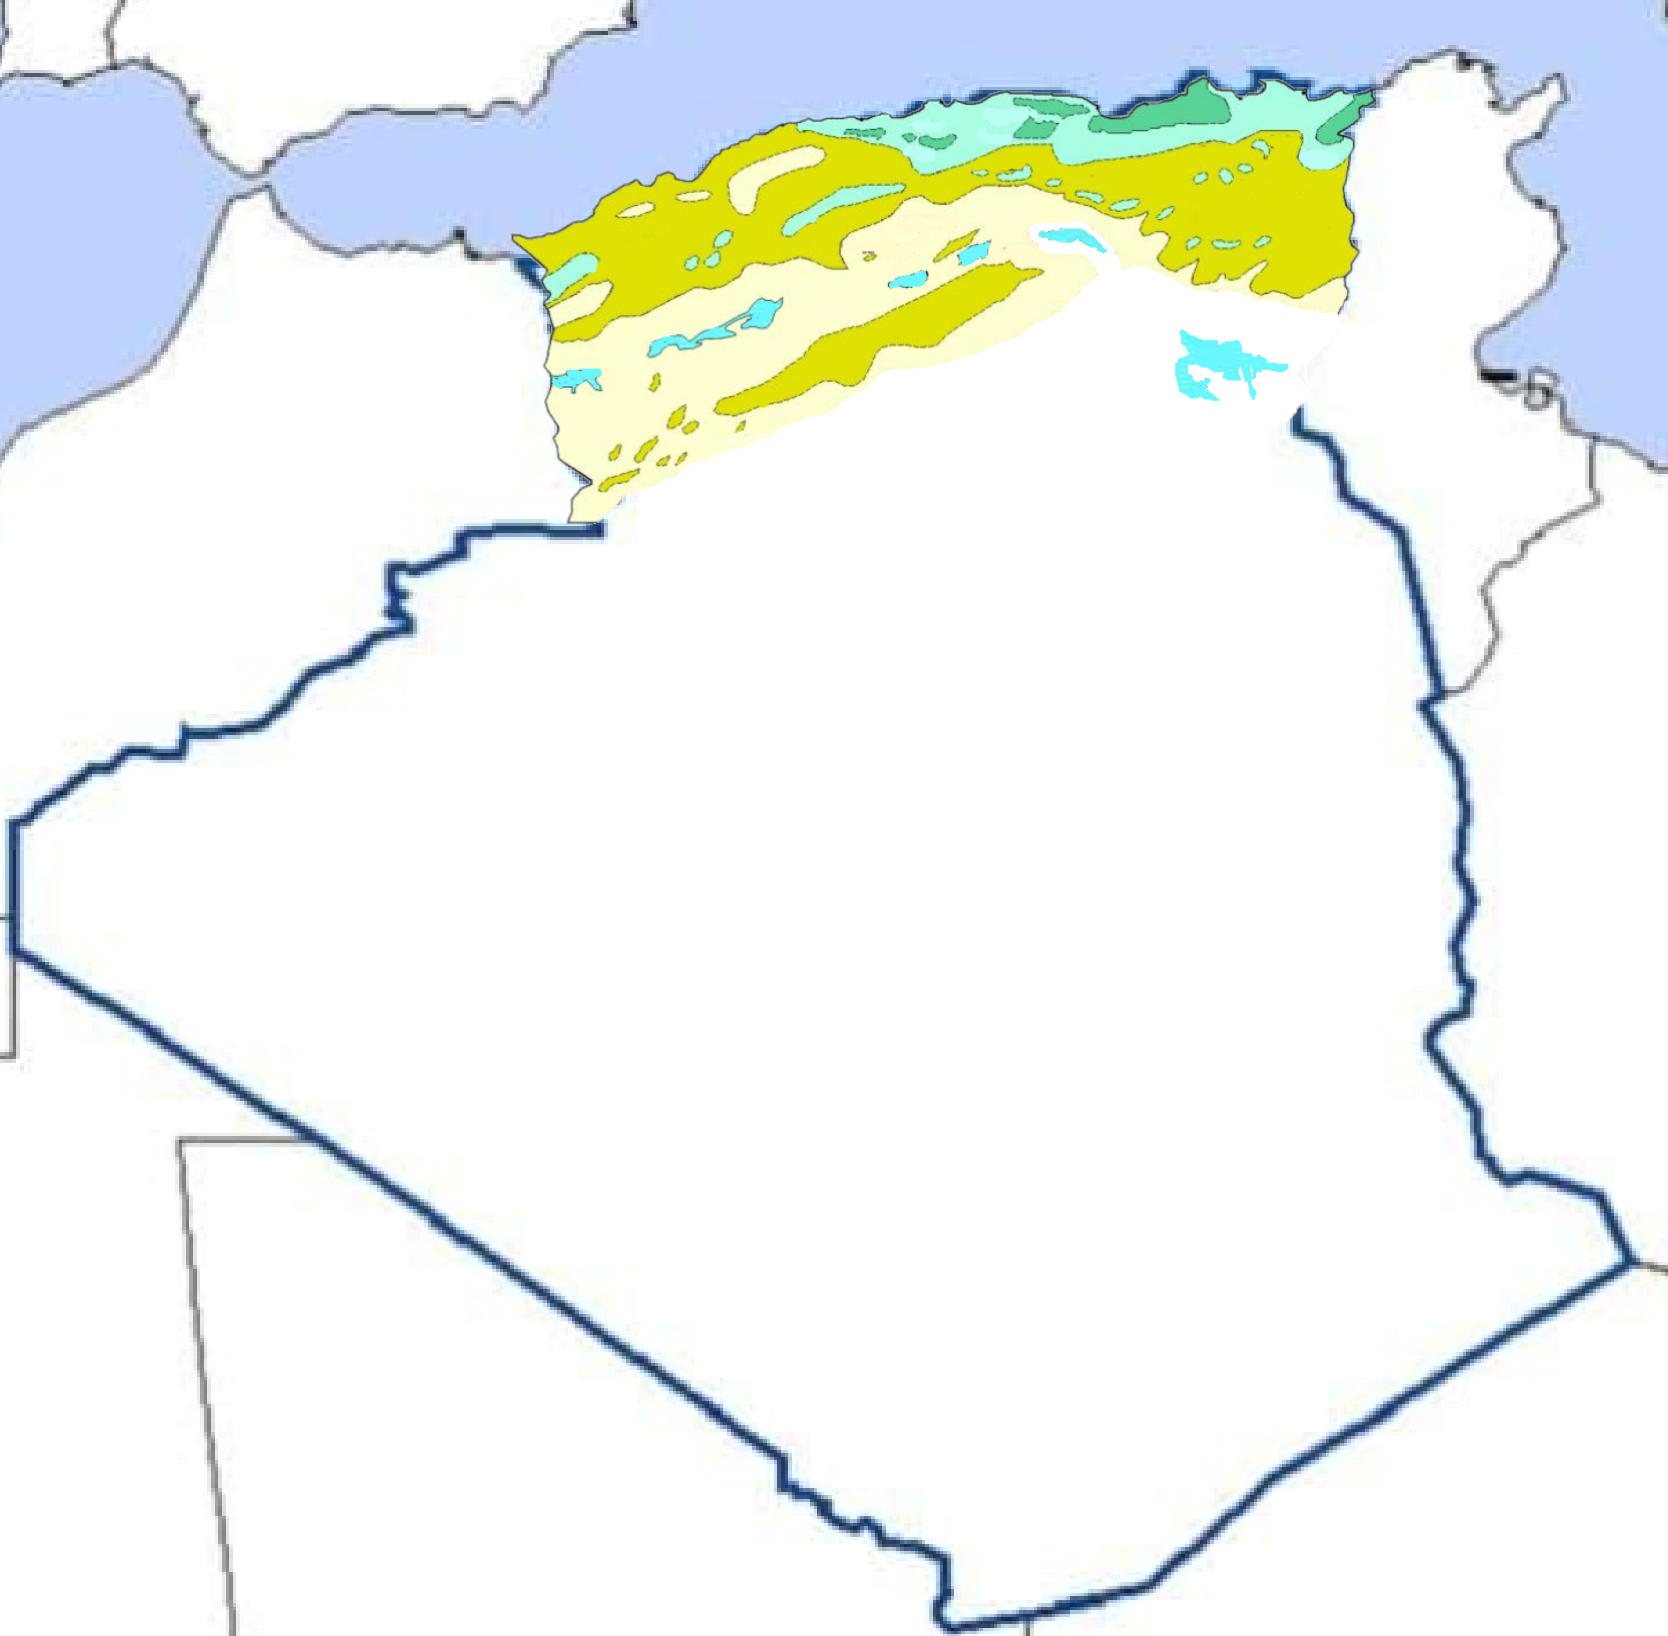

In [17]:

soil = folium.Map(location=[30, 0], zoom_start=4)
# Add a new image layer
folium.raster_layers.ImageOverlay(
    image='etage_bioclimatique.png',
    bounds=[[19, -8.6], [38.1, 12.5]],
    opacity=0.7,
    name='My Image Layer'
).add_to(soil)
soil.save('climat.html')
# Save the map and display it
soil

After adding the new map scan layer by georeferencing, we choose to extract properties using a medium precision segmentation

In [24]:
# Dictionary of colors with their labels for bioclimatic stages
color_dict2 = {
    'CHOTT': (105, 246, 255),
    'HUMID': (88, 211, 150),
    'SUB HUMID': (168, 253, 227),
    'SEMI ARID': (223, 225, 0),
    'ARID': (255, 245, 208),
    'HYPER ARID': (255, 255, 255)
}


color_list2 = []

# Load map image
map_image = Image.open("climat.png")  # Replace "map.png" with your map image file

# Define the bounding box of the map in terms of latitude and longitude
# (min_latitude, min_longitude, max_latitude, max_longitude)
map_bbox = (19, -8.6, 38.1, 12.5)  # Example bounding box bounds=[[19, -8.6], [38.1, 12.5]],

# Determine the size of the map image in pixels
map_width, map_height = map_image.size

# Define the projection for the map (e.g., Web Mercator)
map_projection = Proj(init='epsg:3857')

# Convert latitude and longitude coordinates to pixel coordinates
def lat_lon_to_pixel(lat, lon):
    # Transform latitude and longitude to the map's projection
    x, y = transform(Proj(init='epsg:4326'), map_projection, lon, lat)
    # Scale the transformed coordinates to fit within the map image size
    pixel_x = int((x - map_projection(map_bbox[1], map_bbox[0])[0]) /
                  (map_projection(map_bbox[3], map_bbox[0])[0] - map_projection(map_bbox[1], map_bbox[0])[0]) * map_width)
    pixel_y = int((map_projection(map_bbox[3], map_bbox[0])[1] - y) /
                  (map_projection(map_bbox[3], map_bbox[2])[1] - map_projection(map_bbox[3], map_bbox[0])[1]) * map_height)
    return pixel_x, pixel_y


# Define intervals for latitude and longitude
latitude_interval = (19, 38.1)  # Example latitude interval
longitude_interval = (-8.1, 12.5)  # Example longitude interval

# Define segment size as medium
latitude_step = 0.5  
longitude_step = 0.5  


# Generate latitude and longitude coordinates within the intervals
locations = []
for lat in range(int(latitude_interval[0] * 100), int(latitude_interval[1] * 100), int(latitude_step * 100)):
    for lon in range(int(longitude_interval[0] * 100), int(longitude_interval[1] * 100), int(longitude_step * 100)):
        locations.append((lat / 100, lon / 100))

# Loop over each location and get the color
for latitude, longitude in locations:
    # Convert latitude and longitude to pixel coordinates
    pixel_x, pixel_y = lat_lon_to_pixel(latitude, longitude)

    # Get the color of the pixel at the specified location
    pixel_color = map_image.getpixel((pixel_x, pixel_y))

    # Find the most similar color from the dictionary
    c, n = find_most_similar_color(pixel_color, color_dict2)
    color_list2.append({"latitude": latitude, "longitude": longitude, "color": pixel_color, "most similar": c, "type": n})

This extraction is much faster, and performs in only 2 minutes.

In [20]:
df = pd.DataFrame(color_list2)
df.to_csv('climats_types.csv', index=True)

In [23]:
color_list2[1000]

{'latitude': 30.5,
 'longitude': 8.9,
 'color': (249, 246, 239),
 'most similar': (255, 255, 255),
 'type': 'HYPER ARID'}

Let's now visualize and analyze the extracted data

In [22]:
len(color_list)

96068

In [21]:
len(color_list2)

1638

Let's now verify the accuracy of the obtained data

In [27]:
import numpy as np
# Load the extracted soil types data
df = pd.read_csv('extracted_soil_types.csv')
df

,Unnamed: 0,latitude,longitude,color,most similar,type
0,0,9.9,-16.1,"(230, 242, 246)","(212, 212, 212)",LP
1,1,9.9,-16.0,"(230, 242, 246)","(212, 212, 212)",LP
2,2,9.9,-15.9,"(230, 242, 246)","(212, 212, 212)",LP
3,3,9.9,-15.8,"(230, 242, 246)","(212, 212, 212)",LP
4,4,9.9,-15.7,"(230, 242, 246)","(212, 212, 212)",LP
...,...,...,...,...,...,...
96063,96063,39.0,16.3,"(250, 250, 248)","(255, 250, 204)",GY
96064,96064,39.0,16.4,"(251, 250, 249)","(255, 250, 204)",GY
96065,96065,39.0,16.5,"(250, 250, 247)","(255, 250, 204)",GY
96066,96066,39.0,16.6,"(250, 250, 248)","(255, 250, 204)",GY


We can notice low matching quality in boudaries, and high matching quality in the rest of the map.

In [29]:
import ast  
# First, convert the color tuples from strings to actual tuples if needed
df['color'] = df['color'].apply(ast.literal_eval)
df['most similar'] = df['most similar'].apply(ast.literal_eval)

# Extract RGB components into separate columns
df[['R_cell', 'G_cell', 'B_cell']] = pd.DataFrame(df['color'].tolist(), index=df.index)
df[['R_legend', 'G_legend', 'B_legend']] = pd.DataFrame(df['most similar'].tolist(), index=df.index)

# Calculate normalized Euclidean distance for each row
df['delta_E'] = (1/255) * np.sqrt(
    (df['R_cell'] - df['R_legend'])**2 +
    (df['G_cell'] - df['G_legend'])**2 +
    (df['B_cell'] - df['B_legend'])**2
)

# Calculate Mean Accuracy (MA)
mean_accuracy = 1 - df['delta_E'].mean()

print(f"Mean Accuracy (MA): {mean_accuracy:.4f} or {mean_accuracy*100:.2f}%")

# Calculate accuracy per soil type
if 'type' in df.columns:
    type_accuracy = 1 - df.groupby('type')['delta_E'].mean()
    print("\nAccuracy by soil type:")
    print(type_accuracy.sort_values(ascending=False))

Mean Accuracy (MA): 0.8299 or 82.99%

Accuracy by soil type:
type
AR    0.950036
RG    0.944961
LP    0.861746
GY    0.832652
WR    0.800261
NT    0.777612
CM    0.762362
FL    0.744024
CL    0.731837
SC    0.723456
LV    0.619680
VR    0.422431
Name: delta_E, dtype: float64


In [30]:
df = pd.read_csv('climats_types.csv')
df

,Unnamed: 0,latitude,longitude,color,most similar,type
0,0,19.0,-8.1,"(240, 242, 227)","(255, 245, 208)",ARID
1,1,19.0,-7.6,"(232, 242, 220)","(255, 245, 208)",ARID
2,2,19.0,-7.1,"(242, 239, 233)","(255, 245, 208)",ARID
3,3,19.0,-6.6,"(242, 239, 233)","(255, 245, 208)",ARID
4,4,19.0,-6.1,"(240, 238, 231)","(255, 245, 208)",ARID
...,...,...,...,...,...,...
1633,1633,38.0,10.4,"(183, 210, 245)","(168, 253, 227)",SUB HUMID
1634,1634,38.0,10.9,"(183, 210, 245)","(168, 253, 227)",SUB HUMID
1635,1635,38.0,11.4,"(183, 210, 245)","(168, 253, 227)",SUB HUMID
1636,1636,38.0,11.9,"(183, 210, 244)","(168, 253, 227)",SUB HUMID


In [31]:
# First, convert the color tuples from strings to actual tuples if needed
df['color'] = df['color'].apply(ast.literal_eval)
df['most similar'] = df['most similar'].apply(ast.literal_eval)

# Extract RGB components into separate columns
df[['R_cell', 'G_cell', 'B_cell']] = pd.DataFrame(df['color'].tolist(), index=df.index)
df[['R_legend', 'G_legend', 'B_legend']] = pd.DataFrame(df['most similar'].tolist(), index=df.index)

# Calculate normalized Euclidean distance for each row
df['delta_E'] = (1/255) * np.sqrt(
    (df['R_cell'] - df['R_legend'])**2 +
    (df['G_cell'] - df['G_legend'])**2 +
    (df['B_cell'] - df['B_legend'])**2
)

# Calculate Mean Accuracy (MA)
mean_accuracy = 1 - df['delta_E'].mean()

print(f"Mean Accuracy (MA): {mean_accuracy:.4f} or {mean_accuracy*100:.2f}%")

# Calculate accuracy per climate type
if 'type' in df.columns:
    type_accuracy = 1 - df.groupby('type')['delta_E'].mean()
    print("\nAccuracy by climate type:")
    print(type_accuracy.sort_values(ascending=False))

Mean Accuracy (MA): 0.9152 or 91.52%

Accuracy by climate type:
type
HYPER ARID    0.951832
ARID          0.887475
SUB HUMID     0.809889
SEMI ARID     0.717488
HUMID         0.657070
Name: delta_E, dtype: float64


## Impact of precision on accuracy:

In [32]:
#we choose another precision level for climate types to compare the accuracy.
color_list3 = []

# lower segment size to make higher precision 
latitude_step = 0.1  
longitude_step = 0.1  


# Generate latitude and longitude coordinates within the intervals
locations = []
for lat in range(int(latitude_interval[0] * 100), int(latitude_interval[1] * 100), int(latitude_step * 100)):
    for lon in range(int(longitude_interval[0] * 100), int(longitude_interval[1] * 100), int(longitude_step * 100)):
        locations.append((lat / 100, lon / 100))

# Loop over each location and get the color
for latitude, longitude in locations:
    # Convert latitude and longitude to pixel coordinates
    pixel_x, pixel_y = lat_lon_to_pixel(latitude, longitude)

    # Get the color of the pixel at the specified location
    pixel_color = map_image.getpixel((pixel_x, pixel_y))

    # Find the most similar color from the dictionary
    c, n = find_most_similar_color(pixel_color, color_dict2)
    color_list3.append({"latitude": latitude, "longitude": longitude, "color": pixel_color, "most similar": c, "type": n})

The extraction now took 43 minutes.

In [34]:
len(color_list3)

39346

In [35]:
color_list3[1000]

{'latitude': 19.4,
 'longitude': 9.5,
 'color': (253, 250, 241),
 'most similar': (255, 255, 255),
 'type': 'HYPER ARID'}

In [42]:
df = pd.DataFrame(color_list3)
df.to_csv('climats_types2.csv', index=True)

In [43]:
df = pd.read_csv('climats_types2.csv')

# First, convert the color tuples from strings to actual tuples if needed
df['color'] = df['color'].apply(ast.literal_eval)
df['most similar'] = df['most similar'].apply(ast.literal_eval)

# Extract RGB components into separate columns
df[['R_cell', 'G_cell', 'B_cell']] = pd.DataFrame(df['color'].tolist(), index=df.index)
df[['R_legend', 'G_legend', 'B_legend']] = pd.DataFrame(df['most similar'].tolist(), index=df.index)

# Calculate normalized Euclidean distance for each row
df['delta_E'] = (1/255) * np.sqrt(
    (df['R_cell'] - df['R_legend'])**2 +
    (df['G_cell'] - df['G_legend'])**2 +
    (df['B_cell'] - df['B_legend'])**2
)

# Calculate Mean Accuracy (MA)
mean_accuracy = 1 - df['delta_E'].mean()

print(f"Mean Accuracy (MA): {mean_accuracy:.4f} or {mean_accuracy*100:.2f}%")

# Calculate accuracy per climate type
if 'type' in df.columns:
    type_accuracy = 1 - df.groupby('type')['delta_E'].mean()
    print("\nAccuracy by climate type:")
    print(type_accuracy.sort_values(ascending=False))

Mean Accuracy (MA): 0.9191 or 91.91%

Accuracy by climate type:
type
HYPER ARID    0.952283
ARID          0.895620
CHOTT         0.868634
SUB HUMID     0.804420
SEMI ARID     0.719900
HUMID         0.667789
Name: delta_E, dtype: float64


## Datasets integration into a relational database

In [45]:
import sqlite3
# Connect to the database
conn = sqlite3.connect('my_database.db')  # Replace with your DB file
cursor = conn.cursor()

In [46]:
df = pd.read_sql_query("SELECT * FROM crop", conn)

In [63]:
df

,Crop,Ar,Fr,Climate,Loam,Silt,Sand,Water,Months,Temp_Min,...,Rainfall_min mm_year,Rainfall_max,Farming,Veg,Fruit,Indust,Med,Agro,Weeks,Observation
0,Alfalfa,البرسيم,Luzerne,Temperate,✓,✓,✓,High,"March, April, May, June",-5,...,500,800,1.0,NaN,NaN,NaN,NaN,1.0,6w-8w,"6-8 weeks for the first harvest, subsequent ha..."
1,Almonds,اللوز,Amandes,Mediterranean,✓,None,None,Moderate to High,"February, March, April",-5,...,600,1000,NaN,NaN,NaN,NaN,NaN,1.0,5y-6y,"5-6 years to reach full production, first harv..."
2,Aloe Vera,صبار,Aloè Vera,Arid,✓,✓,None,Low,Year-round,10,...,400,600,NaN,NaN,NaN,NaN,1.0,NaN,2y-3y,2-3 years to reach maturity and start producin...
3,Apples,التفاح,Pommes,Temperate,✓,✓,✓,Moderate to High,"September, October, November",-2,...,600,1000,NaN,NaN,1.0,NaN,NaN,1.0,2y-5y,2-5 years to produce fruit after planting
4,Apricot,مشمش,Abricot,Temperate,✓,✓,None,Moderate to High,"January, February, March",-2,...,600,1000,NaN,NaN,1.0,NaN,NaN,1.0,3y-4y,3-4 years to start producing fruit after planting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,Valerian,الناردين,Valériane,Temperate,✓,✓,✓,Moderate,"April, May, June",15,...,500,800,NaN,NaN,NaN,NaN,1.0,NaN,2y-3y,2-3 years to reach maturity for harvest
101,Walnuts,الجوز,Noix,Temperate,✓,None,None,Moderate to High,"February, March, April, September",-15,...,600,1500,NaN,NaN,NaN,NaN,NaN,1.0,4y-7y,4-7 years to start producing nuts after planting
102,Watermelons,بطيخ أحمر,Pasteques,Tropical,✓,✓,✓,High,"April, May, June",20,...,500,800,NaN,NaN,1.0,NaN,NaN,NaN,80d-100d,80-100 days from planting to harvest
103,Wheat,قمح,Blé,Temperate,✓,✓,✓,Moderate,"September, October, November",10,...,300,600,1.0,NaN,NaN,1.0,NaN,1.0,90d-120d,Approximately 90-120 days from planting to har...


To simplify manipulation in this notebook, we can handle relational tables content as xlsx or csv files to avoid going through DBMS, as in the following examples:

In [79]:
df = pd.read_excel("Crops.xlsx")
df

,Crop,Ar,Fr,Climate,Loam,Silt,Sand,Water,Months,Temp_Min,...,Rainfall_min_mm_year,Rainfall_max,Farming,Veg,Fruit,Indust,Med,Agro,Weeks,Observation
0,Alfalfa,البرسيم,Luzerne,Temperate,✓,✓,✓,High,"March, April, May, June",-5,...,500,800,1.0,NaN,NaN,NaN,NaN,1.0,6w-8w,"6-8 weeks for the first harvest, subsequent ha..."
1,Almonds,اللوز,Amandes,Mediterranean,✓,NaN,NaN,Moderate to High,"February, March, April",-5,...,600,1000,NaN,NaN,NaN,NaN,NaN,1.0,5y-6y,"5-6 years to reach full production, first harv..."
2,Aloe Vera,صبار,Aloè Vera,Arid,✓,✓,NaN,Low,Year-round,10,...,400,600,NaN,NaN,NaN,NaN,1.0,NaN,2y-3y,2-3 years to reach maturity and start producin...
3,Apples,التفاح,Pommes,Temperate,✓,✓,✓,Moderate to High,"September, October, November",-2,...,600,1000,NaN,NaN,1.0,NaN,NaN,1.0,2y-5y,2-5 years to produce fruit after planting
4,Apricot,مشمش,Abricot,Temperate,✓,✓,NaN,Moderate to High,"January, February, March",-2,...,600,1000,NaN,NaN,1.0,NaN,NaN,1.0,3y-4y,3-4 years to start producing fruit after planting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,Valerian,الناردين,Valériane,Temperate,✓,✓,✓,Moderate,"April, May, June",15,...,500,800,NaN,NaN,NaN,NaN,1.0,NaN,2y-3y,2-3 years to reach maturity for harvest
101,Walnuts,الجوز,Noix,Temperate,✓,NaN,NaN,Moderate to High,"February, March, April, September",-15,...,600,1500,NaN,NaN,NaN,NaN,NaN,1.0,4y-7y,4-7 years to start producing nuts after planting
102,Watermelons,بطيخ أحمر,Pasteques,Tropical,✓,✓,✓,High,"April, May, June",20,...,500,800,NaN,NaN,1.0,NaN,NaN,NaN,80d-100d,80-100 days from planting to harvest
103,Wheat,قمح,Blé,Temperate,✓,✓,✓,Moderate,"September, October, November",10,...,300,600,1.0,NaN,NaN,1.0,NaN,1.0,90d-120d,Approximately 90-120 days from planting to har...


In [77]:
df2 = pd.read_csv("sample.csv", delimiter=";")
df2

,Lat,Lon,WILAYA,Commune,OWNER,FIELD,N,P,K,humidity,ph,type,Ec
0,27.956759,-0.304190,ADRAR,OULED AHMED TAMI,42,83,86,36,24,42.891873,5.787268,NT,0.88
1,27.957332,-0.343076,ADRAR,OULED AHMED TAMI,42,83,79,45,20,49.245380,5.715209,NT,0.90
2,27.958906,-0.376292,ADRAR,OULED AHMED TAMI,42,83,63,35,16,45.355499,6.272418,NT,0.88
3,27.967779,-0.423117,ADRAR,BOUDA,43,84,75,53,18,49.437534,6.864794,WR,0.70
4,27.973503,-0.422793,ADRAR,BOUDA,43,84,76,48,18,49.634812,5.775978,WR,0.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,36.898295,7.659801,ANNABA,SERAIDI,28,59,78,35,44,84.673536,7.072656,CL,0.90
174,36.898879,7.675933,ANNABA,SERAIDI,14,25,85,52,45,82.366990,7.224286,CL,0.70
175,36.899295,7.659801,ANNABA,SERAIDI,14,26,91,35,38,80.525861,6.134287,CL,1.20
176,36.912611,7.661882,ANNABA,SERAIDI,14,26,76,49,42,84.479634,5.206373,VR,1.20


Now, we show how we can layer analytical dimensions and facts on the map to make navigation through the data easier than manual SQL queries:

Different queries and procedures are used to embed insights and navigate through the data on top of the map:

Here are some examples of queries and views to efficiently fetch the database:

In [116]:
crop_recommendations_per_month = """
SELECT 
    s.lat, 
    s.lon, 
    s.N, 
    s.P, 
    s.K, 
    s.ph, 
    s.Ec, 
    a.type_climat,
    a.type_soil, 
    cl.Prc_mm_m, 
    cl.Prc_mm_d,
    cl.Prc_cv, 
    cl.Wet_Days,
    cl.Tmp_min, 
    cl.Tmp_max, 
    cl.Tmp_Mean, 
    cl.Gmd_Frost, 
    cl.Rel_Hum,
    c.Crop, 
    c.observation
FROM 
    sample s, 
    crop c, 
    area a, 
    wilaya w, 
    climat_stat cl
WHERE 
    cl.Month = 11
    AND a.wilaya_id = w.id
    AND UPPER(s.Wilaya) = UPPER(w.name)
    AND UPPER(cl.WILAYA) = UPPER(w.name)
    AND c.Temp_Mean BETWEEN cl.Tmp_Mean - 5 AND cl.Tmp_Mean + 5
    AND (
        (a.type_soil IN ('VR','CM','LV','NT') AND c.Loam = '√'
        OR a.type_soil IN ('FL','LV','SC','RG') AND c.Silt = '√'
        OR a.type_soil IN ('AR','RG') AND c.Sand = '√'
    )
    AND (
        (a.type_climat LIKE '%ARID%' AND c.Climate LIKE '%Arid%')
        OR (a.type_climat LIKE '%HUMID%' AND c.Climate LIKE '%Humid%')
        OR (a.type_climat LIKE '%CHOTT%' AND c.Climate LIKE '%Humid%')
    )
"""


### Data Aggregation by Geographic Location

This code demonstrates how to group agricultural data by geographic coordinates (latitude/longitude) and aggregate various metrics for each location. The approach is designed to prepare data for web or mobile applications, with the notebook serving as an illustration.

### Grouping and Aggregation Code
Group data by latitude/longitude and aggregate metrics


In [118]:

grouped_df = df.groupby(['Lat', 'Lon']).agg(
    # Combine all crop names into an HTML line-break separated string
    crops=('Crop', lambda x: '<br>'.join(x)),
    
    # Soil nutrient averages
    N=('N', 'mean'),
    P=('P', 'mean'),
    K=('K', 'mean'),
    
    # Soil property averages
    ph=('ph', 'mean'),
    Ec=('Ec', 'mean'),
    
    # Climate and soil type (take first occurrence)
    type_climat=('type_climat', 'first'),
    type_soil=('type_soil', 'first'),
    
    # Precipitation metrics
    Prc_mm_m=('Prc_mm_m', 'mean'),
    Prc_mm_d=('Prc_mm_m', 'mean'),
    Prc_cv=('Prc_cv', 'mean'),
    
    # Weather metrics
    Wet_Days=('Wet_Days', 'mean'),
    Tmp_min=('Tmp_min', 'mean'),
    Tmp_max=('Tmp_max', 'mean'),
    Tmp_Mean=('Tmp_Mean', 'mean'),
    
    # Special cases
    Grnd_Frost=('Grnd_Frost', 'first'),  # Take first value (assuming constant)
    Rel_Hum=('Rel_Hum', 'mean')
).reset_index()

This section demonstrates our framework's implementation of meta-visualization techniques for analyzing spatial and temporal patterns. The examples showcase:

Interactive Map Layers: Dynamic overlays combining: 

- Real-time sensor data

- Historical climate trends

- Soil composition maps

- Crop suitability recommendations

Temporal Analysis Components: Integrated time-series visualization of:

- Seasonal climate variations

- Soil nutrient fluctuations

- Crop growth cycles

Implementation Note: While presented here in a notebook environment, these visualizations are designed as modular components for:

- Web Applications: React/Vue.js implementations with Mapbox/Leaflet

- Mobile Platforms: Native iOS/Android SDKs with optimized tile rendering

- Embedded Systems: Lightweight versions for field devices with offline capability

The current simulation approximates the production environment's:
✔ Interactive layer toggling
✔ Cross-filtering capabilities
✔ Responsive design patterns

In [92]:
import pandas as pd
import ipyleaflet
from ipywidgets import HTML


# Read the CSV data
df = pd.read_csv("prop.csv", delimiter=";")
df['recommendation'] = df['observation'] + '. Ideal months: ' + df['months'].astype(str)

# Group the data by latitude and longitude, aggregating crop names into a set
grouped_dfC = df.groupby(['Lat', 'Lon'])['Crop'].agg(set).reset_index()
# Convert the set of crops to a string with each crop on a new line
grouped_dfC['Crop'] = grouped_dfC['Crop'].apply(lambda x: '<br>'.join(x))

# Group the data by latitude and longitude, aggregating crop names into a set
grouped_df = df.groupby(['Lat', 'Lon']).agg(
    crops=('Crop', lambda x: '<br>'.join(x)),
    N=('N', 'mean'),
    P=('P', 'mean'),
    K=('K', 'mean'),
    ph=('ph', 'mean'),
    Ec=('Ec', 'mean'),
    type_climat=('type_climat', 'first'),
    type_soil=('type_soil', 'first'),
    Prc_mm_m=('Prc_mm_m', 'mean'),
    Prc_mm_d=('Prc_mm_d', 'mean'),
    Prc_cv=('Prc_cv', 'mean'),
    Wet_Days=('Wet_Days', 'mean'),
    Tmp_min=('Tmp_min', 'mean'),
    Tmp_max=('Tmp_max', 'mean'),
    Tmp_Mean=('Tmp_Mean', 'mean'),
    Grnd_Frost=('Grnd_Frost', 'first'),
    Rel_Hum=('Rel_Hum', 'mean')
).reset_index()

# Create an interactive map
m = ipyleaflet.Map(center=[34.08, 3.03], zoom_start=4)

# Function for creating marker popups with soil and climate data
def create_popup(row):
  # Access data from grouped_df row (more efficient)
  lat = row['Lat']
  lon = row['Lon']
  crops = row['crops']
  N = row['N']  # Access data from row dictionary
  P = row['P']
  K = row['K']
  ph = row['ph']
  Ec = row['Ec']
  type_climat = row['type_climat']
  type_soil = row['type_soil']
  Prc_mm_m = row['Prc_mm_m']
  Prc_mm_d = row['Prc_mm_d']
  Prc_cv = row['Prc_cv']
  Wet_Days = row['Wet_Days']
  Tmp_min = row['Tmp_min']
  Tmp_max = row['Tmp_max']
  Tmp_Mean = row['Tmp_Mean']
  Grnd_Frost = row['Grnd_Frost']
  Rel_Hum = row['Rel_Hum']

  # Construct popup content with formatted data
  popup_content = f"""
    <div style="font-size: 12px;">
      <b>Location:</b> ({lat:.4f}, {lon:.4f})<br>
      <b>Soil Properties:</b><br>
      N: {N:} |  P: {P:} | K: {K:} | pH: {ph:.2f} |  EC: {Ec:}<br>
      Soil Type: {type_soil}<br>
      <b>Climate Properties:</b><br>
      Bioclimatic Stage: {type_climat}<br>
      Precipitation (mm): Monthly = {Prc_mm_m:} | Daily = {Prc_mm_d:}<br>
      Precipitation Coefficient of Variation: {Prc_cv:}<br>
      Wet Days: {Wet_Days:}<br>
      Temperature: {Tmp_min:}°C  to {Tmp_max:}°C | Mean = {Tmp_Mean:}°C<br>
      Ground Frost: {Grnd_Frost} | Relative Humidity: {Rel_Hum:}%<br>
    """
  return HTML(value=popup_content)


# Add markers with popups
for index, row in grouped_df.iterrows():
  marker = ipyleaflet.Marker(
      location=[row['Lat'], row['Lon']],
      draggable=False,
      popup=create_popup(row)  # Pass row for data access
  )
  # Add the marker to the map
  m.add_layer(marker)

m.zoom = 6
m.layout.height = '600px' 
# Now display the map
display(m)

Map(center=[34.08, 3.03], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [98]:
import ipyleaflet
from ipywidgets import HTML
import matplotlib.pyplot as plt
import io
import base64
import pandas as pd

# Read and validate data
df = pd.read_csv("prop.csv", delimiter=";")
df['recommendation'] = df['observation'] + '. Ideal months: ' + df['months'].astype(str)

climate_stat_df = pd.read_csv("climat_stat.csv", delimiter=",")
sample_df = pd.read_csv("sample.csv", delimiter=";")

# Clean coordinates
sample_df = sample_df.dropna(subset=['Lat', 'Lon'])
sample_df['Lat'] = pd.to_numeric(sample_df['Lat'], errors='coerce')
sample_df['Lon'] = pd.to_numeric(sample_df['Lon'], errors='coerce')
sample_df = sample_df.dropna(subset=['Lat', 'Lon'])

# Calculate initial view
def get_initial_view(df):
    if len(df) == 0:
        return [34.08, 3.03], 6  # Default Algeria view
    
    center = [df['Lat'].mean(), df['Lon'].mean()]
    # Calculate appropriate zoom based on data spread
    lat_range = df['Lat'].max() - df['Lat'].min()
    lon_range = df['Lon'].max() - df['Lon'].min()
    zoom = max(6, min(12, int(10 - (max(lat_range, lon_range) / 5))))
    return center, zoom

center, zoom_start = get_initial_view(sample_df)

# Create map
m = ipyleaflet.Map(
    center=center,
    zoom=zoom_start,
    scroll_wheel_zoom=True,
    zoom_control=True,
    layout={'height': '600px'}
)

# Merge climate data
def find_nearest_climate_data(row):
    wilaya_climate = climate_stat_df[climate_stat_df['WILAYA'] == row['WILAYA']]
    return wilaya_climate.iloc[0] if not wilaya_climate.empty else None

sample_df = sample_df.join(
    sample_df.apply(find_nearest_climate_data, axis=1), 
    rsuffix='_climate'
)

# Create popups with error handling
def create_popup(row):
    try:
        wilaya = row['WILAYA']
        wilaya_climate = climate_stat_df[climate_stat_df['WILAYA'] == wilaya]
        
        if wilaya_climate.empty:
            return HTML(value=f"<div>No climate data for {wilaya}</div>")
        
        plt.figure(figsize=(8, 4))
        plt.plot(wilaya_climate['Month'], wilaya_climate['Tmp_Mean'], 
                marker='o', linestyle='-', label="Average Temperature")
        plt.scatter(3, 12, color='red', label="Current temperature in March")
        plt.grid(True)
        plt.xlabel("Month", fontsize=12)
        plt.ylabel("Temperature (°C)", fontsize=12)
        plt.title(f"Temperature in {wilaya}", fontsize=14)
        plt.legend(fontsize=10)
        plt.tight_layout()
        
        img = io.BytesIO()
        plt.savefig(img, format='png', dpi=100)
        plt.close()
        img_base64 = base64.b64encode(img.getvalue()).decode('utf-8')
        
        popup_content = f"""
        <div style="width:300px;max-height:400px;overflow:auto;padding:10px;">
            <h4 style="margin-top:0;">Temporal Analysis</h4>
            <p>Lat: {row['Lat']:.3f}, Lon: {row['Lon']:.3f}</p>
            <p>Province: {wilaya}</p>
            <img src="data:image/png;base64,{img_base64}" style="width:100%;">
        </div>
        """
        return HTML(value=popup_content)
        
    except Exception as e:
        print(f"Error creating popup: {e}")
        return HTML(value="<div>Error loading data</div>")

# Add markers
for _, row in sample_df.iterrows():
    try:
        if not pd.isna(row['Lat']) and not pd.isna(row['Lon']):
            marker = ipyleaflet.Marker(
                location=[float(row['Lat']), float(row['Lon'])],
                popup=create_popup(row),
                draggable=False
            )
            m.add_layer(marker)
    except Exception as e:
        print(f"Skipping invalid marker: {e}")

# Set bounds after adding all markers
if len(sample_df) > 0:
    m.fit_bounds([
        [sample_df['Lat'].min(), sample_df['Lon'].min()],
        [sample_df['Lat'].max(), sample_df['Lon'].max()]
    ])
m.zoom=6
display(m)

Map(center=[35.56241678915165, 4.081549195238531], controls=(ZoomControl(options=['position', 'zoom_in_text', …

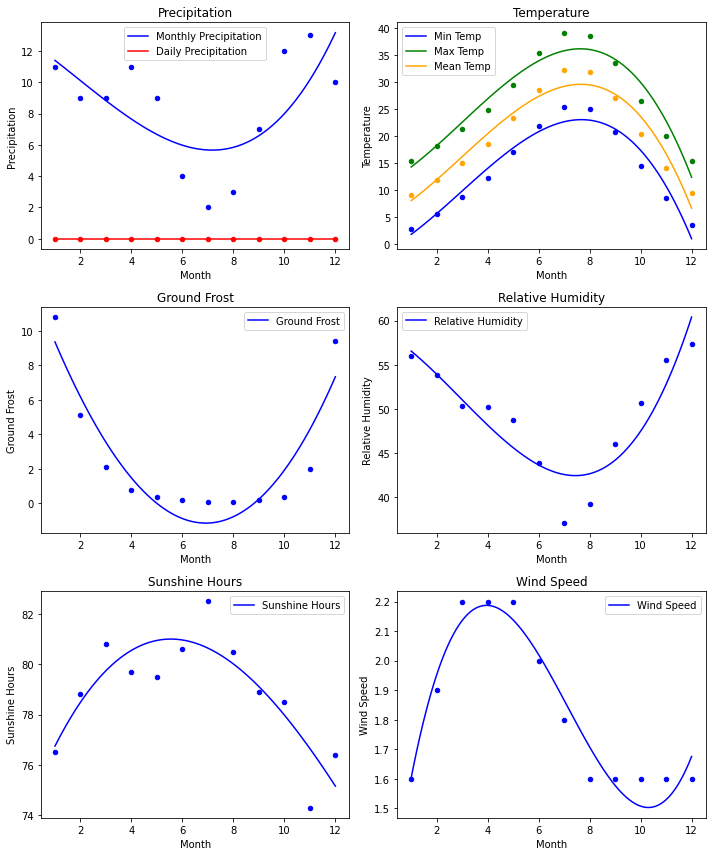

In [106]:
import folium
import numpy as np

sample = pd.read_csv("sample.csv", delimiter=";")
climate = pd.read_csv("climat_stat.csv", delimiter=",")

# Merge data based on Wilaya (using a simplified approach)
def find_nearest_climate_data(row):
    """Finds the closest climate data point based on Wilaya (simplified)."""
    wilaya_climate = climate[climate['WILAYA'] == row['WILAYA']]
    if wilaya_climate.empty:
        return None  # Handle cases where no climate data is found for the Wilaya
    return wilaya_climate.iloc[0]  # Use the first row as an approximation

soil_data = sample.join(sample.apply(find_nearest_climate_data, axis=1), 
                           rsuffix='_climate')

# Create a base map centered on Algeria
m = folium.Map(location=[32.8597, 3.0545], zoom_start=5)

# Select a specific province (replace 'ADRAR' with the desired province)
selected_province = 'BECHAR' 

# Filter the soil data for the selected province
filtered_soil_data = soil_data[soil_data['WILAYA'] == selected_province]

# Create a temporary DataFrame for the selected Wilaya's climate data
wilaya_climate = climate[climate['WILAYA'] == selected_province] 

# Create a figure with subplots (3 rows and 2 columns)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

# Function to plot with polynomial curve fitting
def plot_with_curve(ax, x, y, label, title, color='blue'):
    """
    Plots data with a polynomial curve fit.

    Args:
        ax: Matplotlib axes object.
        x: x-axis data.
        y: y-axis data.
        label: Label for the plot.
        title: Title of the plot.
        color: Color of the plot.
    """
    # Fit a polynomial curve (adjust degree as needed)
    degree = 3  # Example: Degree 3 polynomial
    coefs = np.polyfit(x, y, degree)
    poly = np.poly1d(coefs)

    # Generate smoother x-values for the curve
    x_smooth = np.linspace(x.min(), x.max(), 100) 
    y_smooth = poly(x_smooth)

    ax.plot(x_smooth, y_smooth, color=color, label=label)
    ax.scatter(x, y, color=color, marker='o', s=20)  # Add data points
    ax.set_xlabel("Month")
    ax.set_ylabel(title)
    ax.set_title(title)
    ax.legend()

# Plot Precipitation
plot_with_curve(axes[0, 0], wilaya_climate['Month'], wilaya_climate['Prc_mm_m'], 
                label="Monthly Precipitation", title="Precipitation")
plot_with_curve(axes[0, 0], wilaya_climate['Month'], wilaya_climate['Prc_mm_d'], 
                label="Daily Precipitation", title="Precipitation", color='red')

# Plot Temperature
plot_with_curve(axes[0, 1], wilaya_climate['Month'], wilaya_climate['Tmp_min'], 
                label="Min Temp", title="Temperature")
plot_with_curve(axes[0, 1], wilaya_climate['Month'], wilaya_climate['Tmp_max'], 
                label="Max Temp", title="Temperature", color='green')
plot_with_curve(axes[0, 1], wilaya_climate['Month'], wilaya_climate['Tmp_Mean'], 
                label="Mean Temp", title="Temperature", color='orange')

# Plot Ground Frost
plot_with_curve(axes[1, 0], wilaya_climate['Month'], wilaya_climate['Grnd_Frost'], 
                label="Ground Frost", title="Ground Frost")

# Plot Relative Humidity
plot_with_curve(axes[1, 1], wilaya_climate['Month'], wilaya_climate['Rel_Hum'], 
                label="Relative Humidity", title="Relative Humidity")

# Plot Sunshine Hours
plot_with_curve(axes[2, 0], wilaya_climate['Month'], wilaya_climate['Sun_shine'], 
                label="Sunshine Hours", title="Sunshine Hours")

# Plot Wind Speed
plot_with_curve(axes[2, 1], wilaya_climate['Month'], wilaya_climate['Wind_ms'], 
                label="Wind Speed", title="Wind Speed")

plt.tight_layout()

# Convert plot to HTML for Folium
from io import BytesIO
import base64
img = BytesIO()
plt.savefig(img, format='png')
img.seek(0)
plot_url = 'data:image/png;base64,' + base64.b64encode(img.getvalue()).decode('utf-8')

